# Building and Simulating a lac Operon Model
## Model Development and Parametrisation

,Parameter,Meaning,Value,Units
0,mu,growth/dilution,2.300000e-02,min^-1
1,gamma_M,mRNA decay,4.110000e-01,min^-1
2,gamma_B,β-gal decay,8.330000e-04,min^-1
3,gamma_0,basal mRNA synthesis Γ0,7.250000e-07,mmol·L^-1·min^-1
4,K,transcription constant,7.200000e+03,—
5,K1,transcription constant,2.520000e+04,—
6,alpha_M,activated mRNA synth.,9.970000e-04,mmol·L^-1·min^-1
7,tau_M,transcription delay proxy,1.000000e-01,min
8,tau_B,translation delay proxy,2.000000e+00,min
9,A_ext,allolactose (chemostat),1.000000e+00,mmol·L^-1


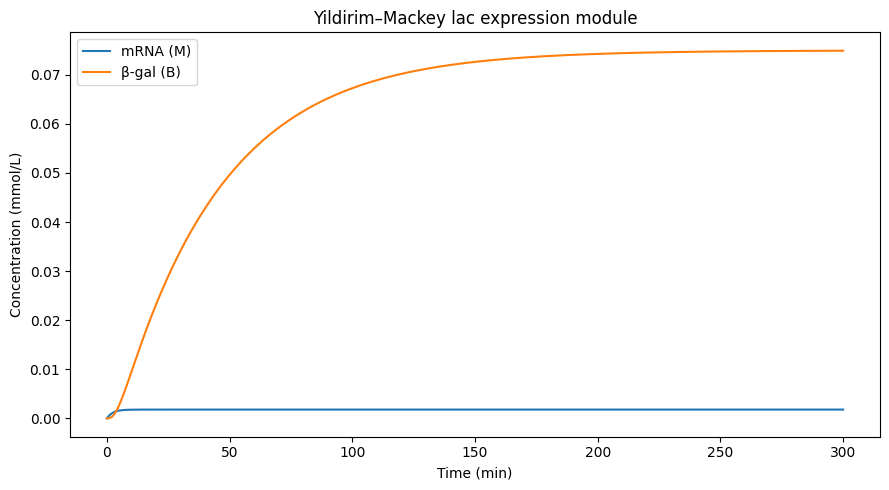

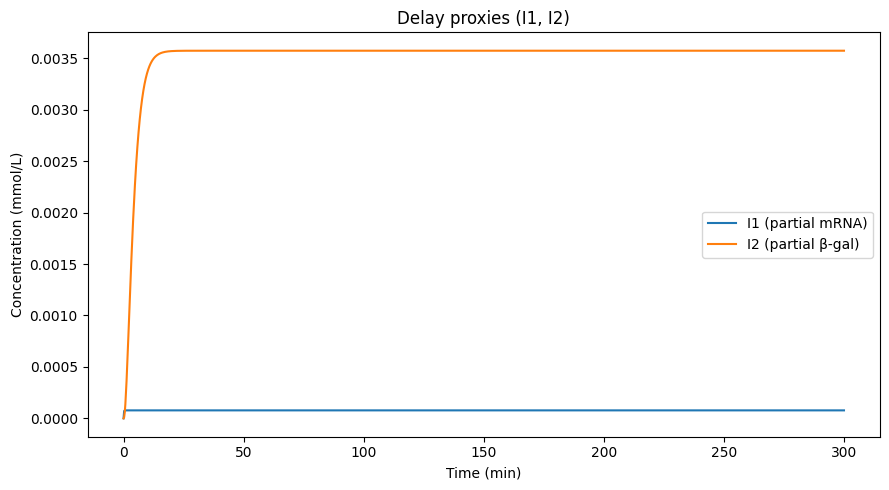

In [3]:
import numpy as np
from scipy.integrate import odeint
import matplotlib.pyplot as plt
import pandas as pd

mu = 0.023
gamma_M = 0.411
gamma_B = 8.33e-4
gamma_0 = 7.25e-7
K = 7200.0
K1 = 25200.0
alpha_M = 9.97e-4 
tau_M = 0.10
tau_B = 2.0
A_ext = 1.0

def f1_allolactose(A):
    e = np.exp(-2.0 * mu * tau_M)
    return (K1 * e * (A**2) + 1.0) / (K + K1 * e * (A**2))


def rhs(y, t):
    I1, M, I2, B = y
    A = A_ext

    v_i1_prod = alpha_M * f1_allolactose(A)
    v_i1_to_M = I1 / tau_M
    v_M_basal = gamma_0
    v_M_deg = (gamma_M + mu) * M

    v_i2_prod = M
    v_i2_to_B = I2 / tau_B
    v_B_deg = (gamma_B + mu) * B

    dI1 = v_i1_prod - v_i1_to_M
    dM = v_i1_to_M + v_M_basal - v_M_deg
    dI2 = v_i2_prod - v_i2_to_B
    dB = v_i2_to_B - v_B_deg

    return [dI1, dM, dI2, dB]

# Initial conditions
y0 = [0.0, 0.0, 0.0, 0.0]
t = np.linspace(0, 300, 1201)

sol = odeint(rhs, y0, t)
I1, M, I2, B = sol.T

# Parameter table
param_rows = [
    ("mu", "growth/dilution", mu, "min^-1"),
    ("gamma_M", "mRNA decay", gamma_M, "min^-1"),
    ("gamma_B", "β-gal decay", gamma_B, "min^-1"),
    ("gamma_0", "basal mRNA synthesis Γ0", gamma_0, "mmol·L^-1·min^-1"),
    ("K", "transcription constant", K, "—"),
    ("K1", "transcription constant", K1, "—"),
    ("alpha_M", "activated mRNA synth.", alpha_M, "mmol·L^-1·min^-1"),
    ("tau_M", "transcription delay proxy",tau_M, "min"),
    ("tau_B", "translation delay proxy", tau_B, "min"),
    ("A_ext", "allolactose (chemostat)", A_ext, "mmol·L^-1"),
]
display(pd.DataFrame(param_rows, columns=["Parameter","Meaning","Value","Units"]))

# Plots
plt.figure(figsize=(9,5))
plt.plot(t, M, label='mRNA (M)')
plt.plot(t, B, label='β-gal (B)')
plt.xlabel('Time (min)'); plt.ylabel('Concentration (mmol/L)')
plt.title('Yildirim–Mackey lac expression module')
plt.legend(); plt.tight_layout(); plt.show()

plt.figure(figsize=(9,5))
plt.plot(t, I1, label='I1 (partial mRNA)')
plt.plot(t, I2, label='I2 (partial β-gal)')
plt.xlabel('Time (min)'); plt.ylabel('Concentration (mmol/L)')
plt.title('Delay proxies (I1, I2)')
plt.legend(); plt.tight_layout(); plt.show()


# Demonstrating Regulation Through Simulation

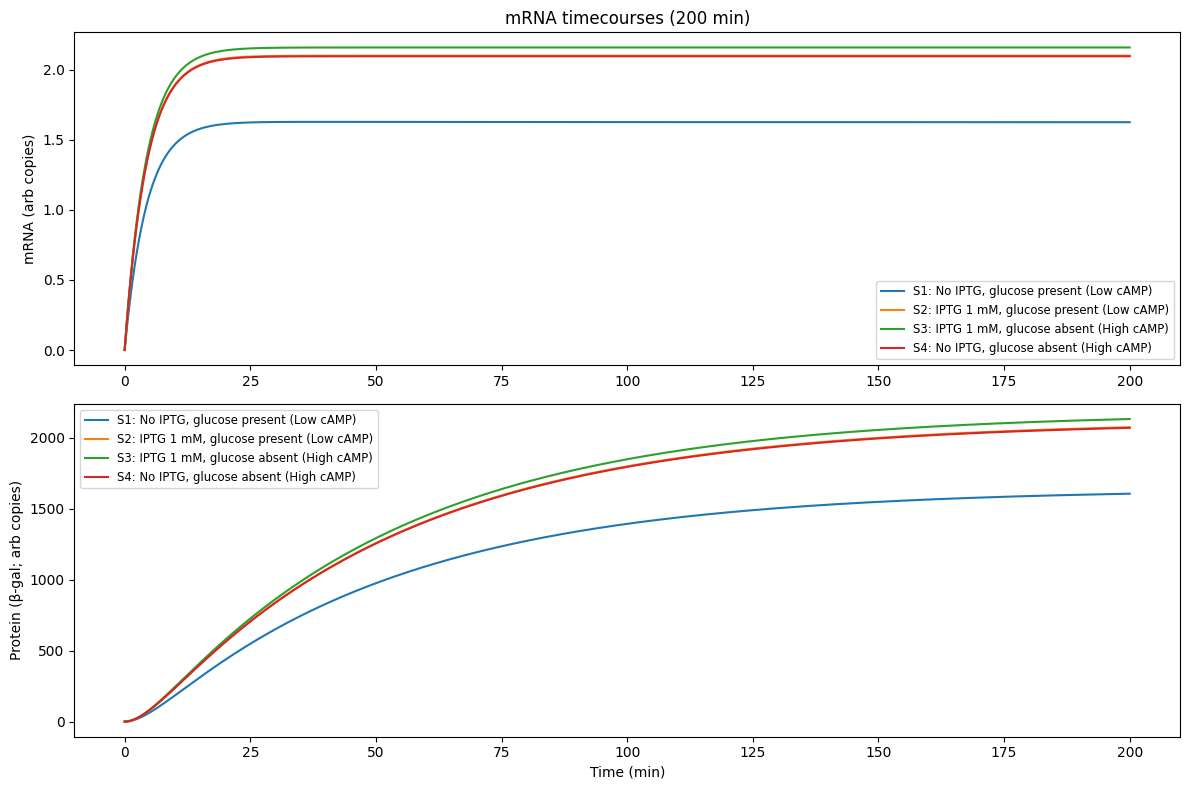

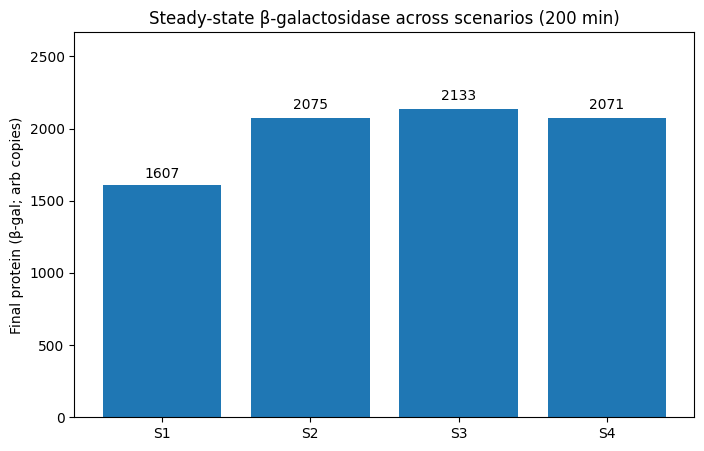

Numeric summary (final protein values):
  Scenario 1: IPTG=0 µM, CAP=1.0 µM -> Protein ≈ 1606.7
  Scenario 2: IPTG=1000 µM, CAP=1.0 µM -> Protein ≈ 2075.4
  Scenario 3: IPTG=1000 µM, CAP=10.0 µM -> Protein ≈ 2133.3
  Scenario 4: IPTG=0 µM, CAP=10.0 µM -> Protein ≈ 2071.1

Fold dynamic range (Scenario 3 / Scenario 1): 1.3
Catabolite repression (Scenario 3 / Scenario 2): 1.0


In [4]:
import numpy as np
from scipy.integrate import odeint
import matplotlib.pyplot as plt

V_cell = 1e-15
N_A = 6.022e23
NA_V = N_A * V_cell
SEC_PER_MIN = 60.0

def M_from_uM(uM):
    return uM * 1e-6

def molecules_per_cell_from_M(M):
    return M * NA_V

def kon_per_min_per_molecule(kon_Ms):
    return kon_Ms * (1.0/(N_A*V_cell)) * SEC_PER_MIN

def koff_per_min(koff_s):
    return koff_s * SEC_PER_MIN

mu = np.log(2.0)/35.0

R_tot = 20.0
k_syn_R = mu * R_tot

O_tot = 1.0

kon_R_Ms = 1e8
koff_R_s = 1e-2
kon_RO = kon_per_min_per_molecule(kon_R_Ms)
koff_RO = koff_per_min(koff_R_s)

kon_C_Ms = 1e7
koff_C_s = 1e-2
kon_CO = kon_per_min_per_molecule(kon_C_Ms)
koff_CO = koff_per_min(koff_C_s)  

Kd_IPTG_M = 1e-4
def frac_LacI_active_from_IPTG_uM(IPTG_uM):
    IPTG_M = M_from_uM(IPTG_uM)
    frac_bound = IPTG_M / (Kd_IPTG_M + IPTG_M) if (Kd_IPTG_M + IPTG_M) > 0 else 0.0
    return 1.0 - frac_bound

alpha_basal = 0.01
alpha_activated = 0.5
alpha_repressed = 0.001

k_tl = 20.0 
gamma_M = np.log(2.0)/3.0 
gamma_P = mu 

# ODE model 
def lac_model(y, t, IPTG_uM, CAP_uM):
    R, RO, OC, M, P = y

    CAP_molecules = molecules_per_cell_from_M(M_from_uM(CAP_uM))

    frac_active = frac_LacI_active_from_IPTG_uM(IPTG_uM)
    R_active = R * frac_active

    O_free = 1.0 - RO - OC
    if O_free < 0.0:
        O_free = 0.0
        s = RO + OC
        if s > 1.0:
            RO *= 1.0/s
            OC *= 1.0/s

    v_bind_RO = kon_RO * R_active * O_free
    v_unbind_RO = koff_RO * RO

    v_bind_CO = kon_CO * CAP_molecules * O_free
    v_unbind_CO = koff_CO * OC

    dR = k_syn_R - mu*R - v_bind_RO + v_unbind_RO
    dRO = v_bind_RO - v_unbind_RO
    dOC = v_bind_CO - v_unbind_CO

    tx = alpha_basal * O_free + alpha_activated * OC + alpha_repressed * RO

    dM = tx - gamma_M * M
    dP = k_tl * M - gamma_P * P

    return [dR, dRO, dOC, dM, dP]

scenarios = {
    1: {"IPTG_uM": 0.0, "CAP_uM": 1.0, "label":"No IPTG, glucose present (Low cAMP)"},
    2: {"IPTG_uM": 1000.0, "CAP_uM": 1.0, "label":"IPTG 1 mM, glucose present (Low cAMP)"},
    3: {"IPTG_uM": 1000.0, "CAP_uM": 10.0, "label":"IPTG 1 mM, glucose absent (High cAMP)"},
    4: {"IPTG_uM": 0.0, "CAP_uM": 10.0, "label":"No IPTG, glucose absent (High cAMP)"},
}

# Simulation
t = np.linspace(0, 200, 1000)

R_init = R_tot
RO_init = 0.0
OC_init = 0.0
M_init = 0.0
P_init = 0.0

results = {}
for idx, s in scenarios.items():
    y0 = [R_init, RO_init, OC_init, M_init, P_init]
    sol = odeint(lac_model, y0, t, args=(s["IPTG_uM"], s["CAP_uM"]))
    R, RO, OC, M, P = sol.T
    results[idx] = {"t": t, "R": R, "RO": RO, "OC": OC, "M": M, "P": P, "label": s["label"],
                    "IPTG_uM": s["IPTG_uM"], "CAP_uM": s["CAP_uM"]}

# Plots
plt.figure(figsize=(12, 8))
for i in [1,2,3,4]:
    r = results[i]
    plt.subplot(2, 1, 1)
    plt.plot(r["t"], r["M"], label=f"S{i}: {r['label']}")
    plt.ylabel("mRNA (arb copies)")
    plt.title("mRNA timecourses (200 min)")
    plt.legend(fontsize='small')

    plt.subplot(2, 1, 2)
    plt.plot(r["t"], r["P"], label=f"S{i}: {r['label']}")
    plt.ylabel("Protein (β-gal; arb copies)")
    plt.xlabel("Time (min)")
    plt.legend(fontsize='small')
plt.tight_layout()
plt.show()

# Bar chart
final_P = [results[i]["P"][-1] for i in [1,2,3,4]]
labels = [f"S{i}" for i in [1,2,3,4]]

plt.figure(figsize=(8,5))
bars = plt.bar(labels, final_P)
plt.ylabel("Final protein (β-gal; arb copies)")
plt.title("Steady-state β-galactosidase across scenarios (200 min)")
for bar, val in zip(bars, final_P):
    plt.text(bar.get_x()+bar.get_width()/2, val*1.02, f"{val:.0f}", ha='center', va='bottom', rotation=0)
plt.ylim(0, max(final_P)*1.25)
plt.show()

# Numeric summary
print("Numeric summary (final protein values):")
for i in [1,2,3,4]:
    val = results[i]["P"][-1]
    print(f"  Scenario {i}: IPTG={results[i]['IPTG_uM']:.0f} µM, CAP={results[i]['CAP_uM']:.1f} µM -> Protein ≈ {val:.1f}")

P_full = results[3]["P"][-1]
P_repressed = results[1]["P"][-1]
P_partial = results[2]["P"][-1]

fold_range = (P_full / P_repressed) if P_repressed > 0 else np.inf
catabolite_ratio = (P_full / P_partial)   if P_partial  > 0 else np.inf
print(f"\nFold dynamic range (Scenario 3 / Scenario 1): {fold_range:.1f}")
print(f"Catabolite repression (Scenario 3 / Scenario 2): {catabolite_ratio:.1f}")


# Deterministic vs. Stochastic Comparison

Running 100 stochastic trajectories...
  10/100
  20/100
  30/100
  40/100
  50/100
  60/100
  70/100
  80/100
  90/100
  100/100


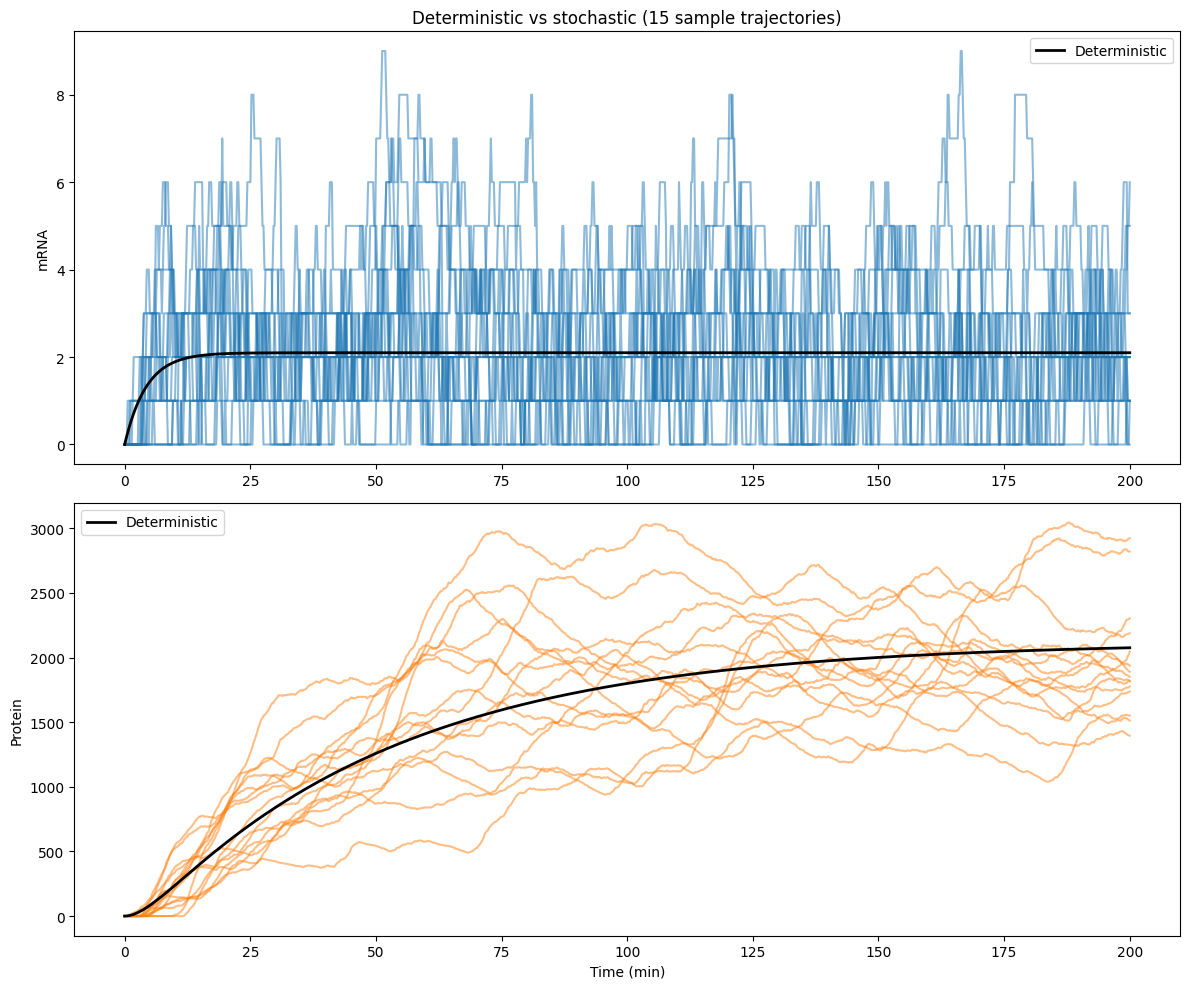

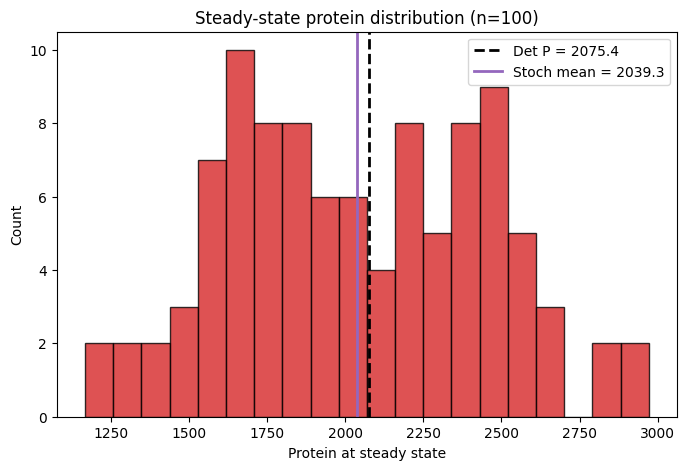

Deterministic final protein: 2075.4
Stochastic mean ± SD: 2039.3 ± 412.1
CV = 0.202
Fano factor = 83.281


In [5]:
import numpy as np
from scipy.integrate import odeint
import matplotlib.pyplot as plt
import random, math
np.random.seed(1)
random.seed(1)

V_cell = 1e-15
N_A = 6.022e23
NA_V = N_A * V_cell
SEC_PER_MIN = 60.0

def M_from_uM(uM): return uM * 1e-6
def molecules_per_cell_from_M(M): return M * NA_V
def kon_per_min_per_molecule(kon_Ms): return kon_Ms * (1.0/(N_A*V_cell)) * SEC_PER_MIN
def koff_per_min(koff_s): return koff_s * SEC_PER_MIN

mu = np.log(2)/35.0

R_tot = 20.0
k_syn_R = mu * R_tot

kon_R_Ms, koff_R_s = 1e8, 1e-2
kon_RO = kon_per_min_per_molecule(kon_R_Ms)
koff_RO = koff_per_min(koff_R_s)

kon_C_Ms, koff_C_s = 1e7, 1e-2
kon_CO = kon_per_min_per_molecule(kon_C_Ms)
koff_CO = koff_per_min(koff_C_s)

Kd_IPTG_M = 1e-4  # 0.1 mM

def frac_LacI_active_from_IPTG(IPTG_uM):
    IPTG_M = M_from_uM(IPTG_uM)
    return 1 - IPTG_M/(Kd_IPTG_M+IPTG_M) if Kd_IPTG_M+IPTG_M>0 else 1

alpha_basal, alpha_activated, alpha_repressed = 0.01, 0.5, 0.001
k_tl = 20.0
gamma_M = np.log(2)/3.0
gamma_P = mu

# Scenario 2
IPTG_uM = 1000.0
CAP_uM = 1.0
C_molecules = molecules_per_cell_from_M(M_from_uM(CAP_uM))
frac_active = frac_LacI_active_from_IPTG(IPTG_uM)

# Deterministic ODE
def lac_model_det(y, t):
    R, RO, OC, M, P = y
    O_free = max(0.0, 1.0 - RO - OC)
    R_active = R * frac_active

    v_bind_RO = kon_RO * R_active * O_free
    v_unbind_RO = koff_RO * RO
    v_bind_CO = kon_CO * C_molecules * O_free
    v_unbind_CO = koff_CO * OC

    dR = k_syn_R - mu*R - v_bind_RO + v_unbind_RO
    dRO = v_bind_RO - v_unbind_RO
    dOC = v_bind_CO - v_unbind_CO
    tx = alpha_basal*O_free + alpha_activated*OC + alpha_repressed*RO
    dM = tx - gamma_M*M
    dP = k_tl*M - gamma_P*P
    return [dR, dRO, dOC, dM, dP]

t_max = 200
t_grid = np.linspace(0, t_max, 1000)
y0_det = [R_tot, 0, 0, 0, 0]
sol_det = odeint(lac_model_det, y0_det, t_grid)
R_det, RO_det, OC_det, M_det, P_det = sol_det.T
P_det_final = P_det[-1]

# Gillespie SSA
def run_gillespie(t_max, record_times):
    R = int(round(R_tot))
    promoter_state = "free"
    M = 0
    P = 0

    out_idx = 0
    records = np.zeros((len(record_times), 5))
    t = 0.0
    while t < t_max:
        O_free = 1 if promoter_state == "free" else 0
        RO_occ = 1 if promoter_state == "RO" else 0
        OC_occ = 1 if promoter_state == "OC" else 0

        a = []
        a.append(k_syn_R)
        a.append(mu * R)
        a.append(kon_RO * (R*frac_active) * O_free)
        a.append(koff_RO * RO_occ)
        a.append(kon_CO * C_molecules * O_free)
        a.append(koff_CO * OC_occ)
        tx_rate = alpha_basal*O_free + alpha_activated*OC_occ + alpha_repressed*RO_occ
        a.append(tx_rate)
        a.append(gamma_M*M)
        a.append(k_tl*M) 
        a.append(gamma_P*P) 

        a0 = sum(a)
        if a0 <= 0: break
        tau = -math.log(np.random.random())/a0
        t_next = t+tau
        while out_idx < len(record_times) and record_times[out_idx] <= t_next:
            records[out_idx] = [R, RO_occ, OC_occ, M, P]
            out_idx += 1

        r = np.random.random()*a0
        acc = 0
        chosen = None
        for i,ai in enumerate(a):
            acc += ai
            if r <= acc:
                chosen = i
                break

        if chosen == 0:
            R += 1
        elif chosen == 1 and R>0:
            R -= 1
        elif chosen == 2 and promoter_state=="free" and R>0:
            promoter_state = "RO"
            R -= 1
        elif chosen == 3 and promoter_state=="RO":
            promoter_state = "free"
            R += 1
        elif chosen == 4 and promoter_state=="free":
            promoter_state = "OC"
        elif chosen == 5 and promoter_state=="OC":
            promoter_state = "free"
        elif chosen == 6:
            M += 1
        elif chosen == 7 and M>0:
            M -= 1
        elif chosen == 8:
            P += 1
        elif chosen == 9 and P>0:
            P -= 1
        t = t_next

    while out_idx < len(record_times):
        records[out_idx] = [R, 1 if promoter_state=="RO" else 0, 1 if promoter_state=="OC" else 0, M, P]
        out_idx += 1

    return records

n_traj = 100
record_times = t_grid
print(f"Running {n_traj} stochastic trajectories...")
all_trajs = np.zeros((n_traj, len(record_times), 5))
for i in range(n_traj):
    all_trajs[i] = run_gillespie(t_max, record_times)
    if (i+1)%10==0:
        print(f"  {i+1}/{n_traj}")

M_trajs = all_trajs[:,:,3]
P_trajs = all_trajs[:,:,4]

# Plot
sel = random.sample(range(n_traj), 15)

plt.figure(figsize=(12, 10))
plt.subplot(2,1,1)
for i in sel:
    plt.plot(t_grid, M_trajs[i], color='C0', alpha=0.5)
plt.plot(t_grid, M_det, color='k', lw=2, label='Deterministic')
plt.ylabel('mRNA')
plt.title('Deterministic vs stochastic (15 sample trajectories)')
plt.legend()

plt.subplot(2,1,2)
for i in sel:
    plt.plot(t_grid, P_trajs[i], color='C1', alpha=0.5)
plt.plot(t_grid, P_det, color='k', lw=2, label='Deterministic')
plt.ylabel('Protein')
plt.xlabel('Time (min)')
plt.legend()
plt.tight_layout()
plt.show()

# Histogram
final_P_vals = P_trajs[:, -1]
mean_P = np.mean(final_P_vals)
std_P = np.std(final_P_vals, ddof=1)
cv_P = std_P/mean_P
fano_P = (std_P**2)/mean_P

plt.figure(figsize=(8,5))
plt.hist(final_P_vals, bins=20, color='C3', edgecolor='k', alpha=0.8)
plt.axvline(P_det_final, color='k', lw=2, linestyle='--', label=f'Det P = {P_det_final:.1f}')
plt.axvline(mean_P, color='C4', lw=2, linestyle='-', label=f'Stoch mean = {mean_P:.1f}')
plt.xlabel('Protein at steady state')
plt.ylabel('Count')
plt.title('Steady-state protein distribution (n=100)')
plt.legend()
plt.show()

print(f"Deterministic final protein: {P_det_final:.1f}")
print(f"Stochastic mean ± SD: {mean_P:.1f} ± {std_P:.1f}")
print(f"CV = {cv_P:.3f}")
print(f"Fano factor = {fano_P:.3f}")


# Understanding Dual Regulation
## The Functional Logic of Activation + Repression

In [6]:
import numpy as np
from scipy.integrate import odeint

V_cell = 1e-15
N_A = 6.022e23
NA_V = N_A * V_cell
SEC_PER_MIN = 60.0

def uM_to_M(uM): return uM * 1e-6
def M_to_molecules(M): return M * NA_V
def uM_to_molecules(uM): return M_to_molecules(uM_to_M(uM))

def kon_per_min_per_molecule(kon_Ms): return kon_Ms * (1.0/(N_A*V_cell)) * SEC_PER_MIN
def koff_per_min(koff_s): return koff_s * SEC_PER_MIN

mu = np.log(2.0) / 35.0

R0 = 20.0
k_syn_R_base = mu * R0

kon_R_Ms, koff_R_s = 1e8, 1e-2
kon_C_Ms, koff_C_s = 1e7, 1e-2
k_on_RO, k_off_RO = kon_per_min_per_molecule(kon_R_Ms), koff_per_min(koff_R_s)
k_on_CO, k_off_CO = kon_per_min_per_molecule(kon_C_Ms), koff_per_min(koff_C_s)

alpha_basal = 0.01
alpha_activated = 0.5
alpha_repressed = 0.001
k_tl = 20.0
gamma_M = np.log(2.0) / 3.0
gamma_P = mu

Kd_IPTG_M = 1e-4  # 0.1 mM
def frac_LacI_active_from_IPTG_uM(IPTG_uM):
    IPTG_M = uM_to_M(IPTG_uM)
    return 1 - IPTG_M/(Kd_IPTG_M+IPTG_M) if Kd_IPTG_M+IPTG_M>0 else 1.0

O_tot = 1.0

t_max = 200.0
n_t = 2001
t = np.linspace(0, t_max, n_t)

# Model builder
def make_lac_ode_model(k_syn_R=k_syn_R_base, CAP_uM_func=lambda scen: 10.0, IPTG_uM_func=lambda scen: 0.0):
    def lac_ode(y, tt, scenario):
        R, RO, OC, M, P = y
        O_free = max(0.0, O_tot - RO - OC)

        CAP_uM = CAP_uM_func(scenario)
        IPTG_uM = IPTG_uM_func(scenario)
        C_molecules = uM_to_molecules(CAP_uM)
        frac_active = frac_LacI_active_from_IPTG_uM(IPTG_uM)

        v_bind_RO = k_on_RO * (R * frac_active) * O_free
        v_unbind_RO = k_off_RO * RO
        v_bind_CO = k_on_CO * C_molecules * O_free
        v_unbind_CO = k_off_CO * OC

        dR = k_syn_R - mu * R - v_bind_RO + v_unbind_RO
        dRO = v_bind_RO - v_unbind_RO
        dOC = v_bind_CO - v_unbind_CO

        tx = alpha_basal*O_free + alpha_activated*OC + alpha_repressed*RO
        dM = tx - gamma_M*M
        dP = k_tl*M - gamma_P*P
        return [dR, dRO, dOC, dM, dP]
    return lac_ode

# Scenarios
def CAP_for_scenario_wt(scen):
    return 1.0 if scen in (1,2) else 10.0

def IPTG_for_scenario(scen):
    return 0.0 if scen in (1,4) else 1000.0

def run_model(ode_func):
    y0 = [R0, 0.0, 0.0, 0.0, 0.0]
    results = {}
    for scen in [1,2,3,4]:
        sol = odeint(lambda y, tt: ode_func(y, tt, scen), y0, t)
        R, RO, OC, M, P = sol.T
        results[scen] = {"R": R, "RO": RO, "OC": OC, "M": M, "P": P}
    return results

ode_wt = make_lac_ode_model(k_syn_R=k_syn_R_base,
                            CAP_uM_func=CAP_for_scenario_wt,
                            IPTG_uM_func=IPTG_for_scenario)

ode_rep = make_lac_ode_model(k_syn_R=k_syn_R_base,
                             CAP_uM_func=lambda s: 10.0,
                             IPTG_uM_func=IPTG_for_scenario)

ode_act = make_lac_ode_model(k_syn_R=0.0,
                             CAP_uM_func=CAP_for_scenario_wt,
                             IPTG_uM_func=lambda s: 0.0)

res_wt = run_model(ode_wt)
res_rep = run_model(ode_rep)
res_act = run_model(ode_act)

def steady_state(arr): return float(arr[-1])
def time_avg_last_fraction(arr, frac=0.2):
    start = int(len(arr)*(1-frac))
    return float(np.mean(arr[start:]))

def analyze(res):
    P_vals = {s: steady_state(res[s]["P"]) for s in res}
    occ = {}
    for s in res:
        O_free = O_tot - res[s]["RO"] - res[s]["OC"]
        occ[s] = {
            "O_free_avg": time_avg_last_fraction(O_free),
            "RO_avg": time_avg_last_fraction(res[s]["RO"]),
            "OC_avg": time_avg_last_fraction(res[s]["OC"]),
        }
    return P_vals, occ

P_wt, occ_wt = analyze(res_wt)
P_rep, occ_rep = analyze(res_rep)
P_act, occ_act = analyze(res_act)

# Fold changes
fold_wt = P_wt[3] / P_wt[1] if P_wt[1] > 0 else np.inf
fold_rep = (0.5*(P_rep[2]+P_rep[3])) / (0.5*(P_rep[1]+P_rep[4])) if (P_rep[1]+P_rep[4])>0 else np.inf
fold_act = (0.5*(P_act[3]+P_act[4])) / (0.5*(P_act[1]+P_act[2])) if (P_act[1]+P_act[2])>0 else np.inf

threshold = 100.0
def high_expression(val): return val >= threshold
truth_table = {}
for scen in [1,2,3,4]:
    lactose_present = scen in (2,3)
    glucose_absent = scen in (3,4)
    truth_table[scen] = {
        "lactose_present": lactose_present,
        "glucose_absent": glucose_absent,
        "high_expression": high_expression(P_wt[scen])
    }

# Print results
print("\nSteady-state protein (P) per scenario")
print("Wild-type:", P_wt)
print("Repression-only:", P_rep)
print("Activation-only:", P_act)

print("\nFold changes")
print(f"Wild-type Scen3/Scen1: {fold_wt:.2f}x")
print(f"Repression-only mean(2,3)/mean(1,4): {fold_rep:.2f}x")
print(f"Activation-only mean(3,4)/mean(1,2): {fold_act:.2f}x")

print("\nPromoter occupancy averages (last 20%)")
for name, occ in [("WT", occ_wt), ("Rep-only", occ_rep), ("Act-only", occ_act)]:
    print(f"\n{name}:")
    for s in [1,2,3,4]:
        print(f"  Scen{s}: free={occ[s]['O_free_avg']:.3f}, RO={occ[s]['RO_avg']:.3f}, OC={occ[s]['OC_avg']:.3f}")

print("\nTruth table (WT)")
print("Scen | Lactose_present | Glucose_absent | High_expression")
for s in [1,2,3,4]:
    row = truth_table[s]
    print(f"{s:>4} | {str(row['lactose_present']):>15} | {str(row['glucose_absent']):>13} | {str(row['high_expression']):>15}")

print("\nSummary")
print("System\t\tFold-change")
print(f"Wild-type\t{fold_wt:.1f}")
print(f"Repression-only\t{fold_rep:.1f}")
print(f"Activation-only\t{fold_act:.1f}")



Steady-state protein (P) per scenario
Wild-type: {1: 1606.7162261659662, 2: 2075.3519700947413, 3: 2133.2716412824816, 4: 2071.0736199448743}
Repression-only: {1: 2071.0736199448743, 2: 2133.2716412824816, 3: 2133.2716412824816, 4: 2071.0736199448743}
Activation-only: {1: 2081.288019836166, 2: 2081.288019836166, 3: 2133.7092877508953, 4: 2133.7092877508953}

Fold changes
Wild-type Scen3/Scen1: 1.33x
Repression-only mean(2,3)/mean(1,4): 1.03x
Activation-only mean(3,4)/mean(1,2): 1.03x

Promoter occupancy averages (last 20%)

WT:
  Scen1: free=0.001, RO=0.249, OC=0.750
  Scen2: free=0.001, RO=0.029, OC=0.970
  Scen3: free=0.000, RO=0.003, OC=0.997
  Scen4: free=0.000, RO=0.032, OC=0.968

Rep-only:
  Scen1: free=0.000, RO=0.032, OC=0.968
  Scen2: free=0.000, RO=0.003, OC=0.997
  Scen3: free=0.000, RO=0.003, OC=0.997
  Scen4: free=0.000, RO=0.032, OC=0.968

Act-only:
  Scen1: free=0.001, RO=0.010, OC=0.989
  Scen2: free=0.001, RO=0.010, OC=0.989
  Scen3: free=0.000, RO=0.001, OC=0.999
  S

# Binding Kinetics vs. Equilibrium

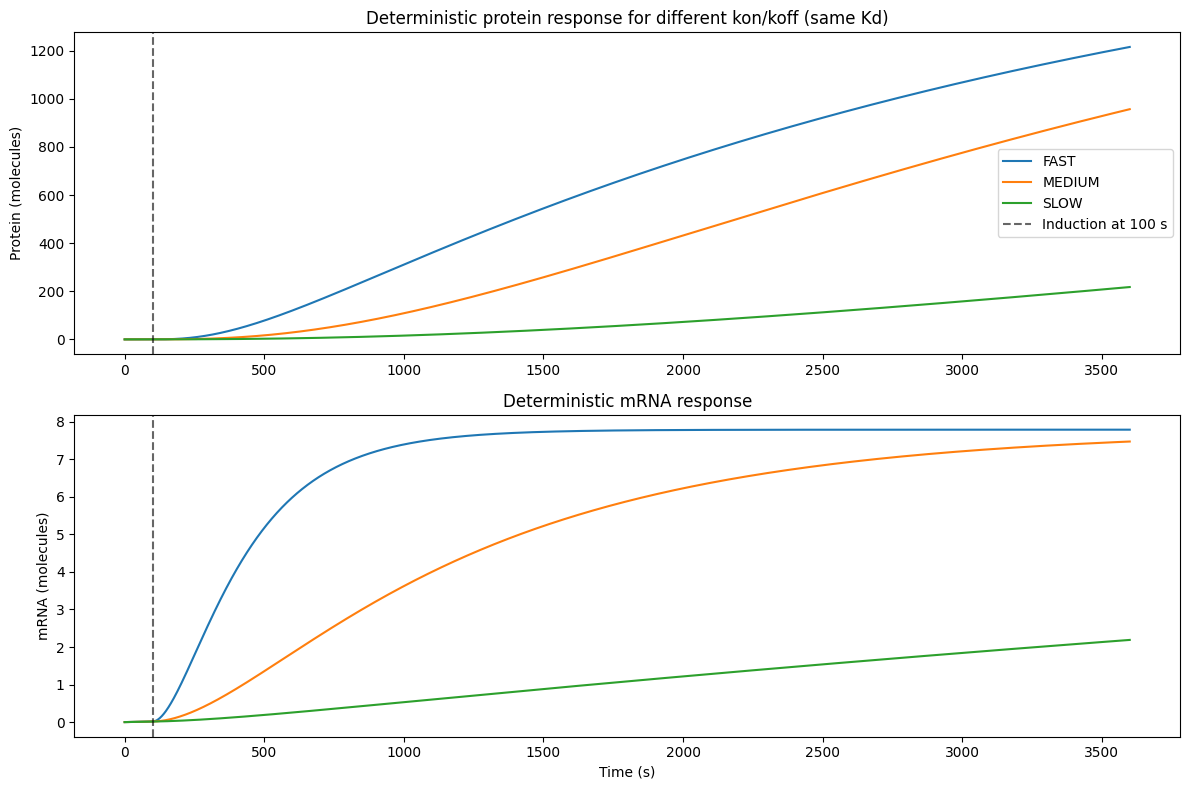

=== Deterministic response times (to 50% of new steady-state protein) ===
  FAST: t_resp ≈ 1507.4 s (P_old=0.02, P_new=1181.50)
MEDIUM: t_resp ≈ 1971.8 s (P_old=0.02, P_new=913.92)
  SLOW: t_resp ≈ 2267.0 s (P_old=0.02, P_new=202.35)


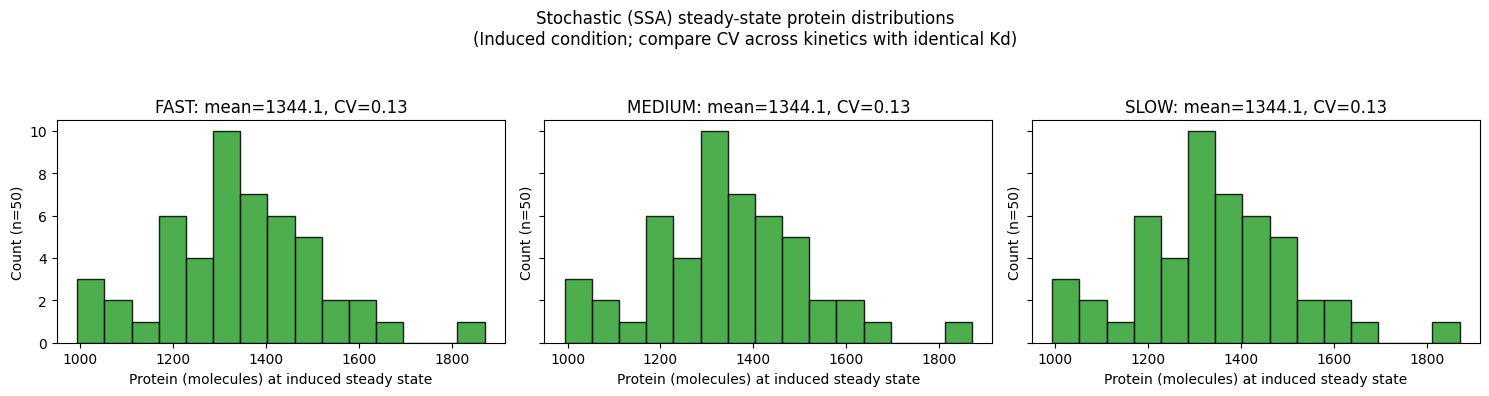

In [7]:
import numpy as np
from scipy.integrate import odeint
import matplotlib.pyplot as plt
import math
import random

V_cell = 1e-15
N_A = 6.022e23
NA_V = N_A * V_cell

def kon_molar_to_per_molecule(kon_molar):
    """Convert M^-1 s^-1 to (molecule^-1 s^-1) for molecule-number states."""
    return kon_molar / NA_V

mu = np.log(2.0) / (35.0 * 60.0)

R0 = 20.0
k_syn_R = mu * R0

t_half_mRNA = 3.0 * 60.0 
gamma_M = np.log(2.0) / t_half_mRNA
gamma_P = mu
k_tl = 0.08

alpha_ON   = 0.03
alpha_leak = 1e-4

O_tot = 1.0 

KINETIC_SETS = {
    "FAST": {"kon_molar": 1e8, "koff": 1e-2},
    "MEDIUM": {"kon_molar": 1e7, "koff": 1e-3},
    "SLOW": {"kon_molar": 1e6, "koff": 1e-4},
}

for k in KINETIC_SETS.values():
    k["kon"] = kon_molar_to_per_molecule(k["kon_molar"])

# ODE model
def ode_rhs(y, t, kon, koff, R_active_func):
    """State y = [R, RO, M, P]; R_active_func(t) returns fraction of LacI that can bind (0..1)."""
    R, RO, M, P = y
    O_free = max(0.0, O_tot - RO)

    R_active = R * R_active_func(t)

    v_bind = kon * R_active * O_free
    v_unbind = koff * RO

    dR = k_syn_R - gamma_P*R - v_bind + v_unbind
    dRO = v_bind - v_unbind
    tx = alpha_ON * O_free + alpha_leak * RO
    dM = tx - gamma_M*M
    dP = k_tl*M - gamma_P*P
    return [dR, dRO, dM, dP]

def simulate_deterministic(kon, koff, t_end=3600, t_switch=100):
    """
    Start repressed; at t_switch set R_active->0 (saturating IPTG).
    Return time grid and solution arrays, plus response time to 50% new SS.
    """
    t = np.linspace(0, t_end, 2001)

    def R_active_frac(tt):
        return 1.0 if tt < t_switch else 0.0

    y0 = [R0, 1.0, 0.0, 0.0]

    sol = odeint(lambda y, tt: ode_rhs(y, tt, kon, koff, R_active_frac), y0, t, atol=1e-9, rtol=1e-7)
    R, RO, M, P = sol.T

    pre_mask = t < (t_switch - 5)
    post_mask = t > (t_end - 300)
    P_old_ss = float(np.mean(P[pre_mask])) if np.any(pre_mask) else float(P[0])
    P_new_ss = float(np.mean(P[post_mask]))

    target = P_old_ss + 0.5*(P_new_ss - P_old_ss)

    after = np.where(t >= t_switch)[0]
    idx_cross = None
    for i in after:
        if P[i] >= target:
            idx_cross = i
            break
    t_resp = t[idx_cross] - t_switch if idx_cross is not None else np.nan

    return t, R, RO, M, P, t_resp, P_old_ss, P_new_ss


def gillespie_induced_steady(kon, koff, t_burn=3000, t_sample=1000, n_traj=50, seed=1):
    """
    Run n_traj SSA trajectories in the induced condition (R_active=0).
    Return array of final proteins and CV.
    """
    rng = np.random.default_rng(seed)
    finals = []

    for _ in range(n_traj):
        # integer state
        R = int(round(R0))
        RO = 0
        M = 0
        P = 0

        t = 0.0
        t_end = t_burn + t_sample

        def propensities():
            O_free = max(0, O_tot - RO)
            a0 = k_syn_R
            a1 = gamma_P * R
            a2 = 0.0
            a3 = koff * RO
            a4 = alpha_ON * O_free + alpha_leak * RO
            a5 = gamma_M * M 
            a6 = k_tl * M 
            a7 = gamma_P * P 
            return np.array([a0,a1,a2,a3,a4,a5,a6,a7], dtype=float)

        while t < t_end:
            a = propensities()
            a0_sum = a.sum()
            if a0_sum <= 0:
                break
            r1 = rng.random()
            tau = -math.log(r1) / a0_sum
            t += tau
            r2 = rng.random() * a0_sum
            acc = 0.0
            rxn = 0
            for i, ai in enumerate(a):
                acc += ai
                if r2 <= acc:
                    rxn = i
                    break
            if rxn == 0:
                R += 1
            elif rxn == 1:
                if R > 0: R -= 1
            elif rxn == 2:
                pass
            elif rxn == 3:
                if RO > 0:
                    RO -= 1
                    R += 1
            elif rxn == 4:
                M += 1
            elif rxn == 5:
                if M > 0: M -= 1
            elif rxn == 6:
                P += 1
            elif rxn == 7:
                if P > 0: P -= 1

        finals.append(P)

    finals = np.array(finals, dtype=float)
    mean = finals.mean()
    std = finals.std(ddof=1) if len(finals) > 1 else 0.0
    cv = std / mean if mean > 0 else np.nan
    return finals, mean, std, cv

# Run simulations

DET_results = {}
SSA_results = {}

t_end = 3600
t_switch = 100

for name, pars in KINETIC_SETS.items():
    t, R, RO, M, P, t_resp, P_old, P_new = simulate_deterministic(
        pars["kon"], pars["koff"], t_end=t_end, t_switch=t_switch
    )
    DET_results[name] = {
        "t": t, "R": R, "RO": RO, "M": M, "P": P,
        "t_resp": t_resp, "P_old": P_old, "P_new": P_new
    }

    finals, mean, std, cv = gillespie_induced_steady(
        pars["kon"], pars["koff"], t_burn=3000, t_sample=1000, n_traj=50, seed=42
    )
    SSA_results[name] = {"finals": finals, "mean": mean, "std": std, "cv": cv}


plt.figure(figsize=(12, 8))

# Protein
plt.subplot(2,1,1)
for name in ["FAST","MEDIUM","SLOW"]:
    plt.plot(DET_results[name]["t"], DET_results[name]["P"], label=f"{name}")
plt.axvline(t_switch, color='k', linestyle='--', alpha=0.6, label="Induction at 100 s")
plt.ylabel("Protein (molecules)")
plt.title("Deterministic protein response for different kon/koff (same Kd)")
plt.legend()

# mRNA
plt.subplot(2,1,2)
for name in ["FAST","MEDIUM","SLOW"]:
    plt.plot(DET_results[name]["t"], DET_results[name]["M"], label=f"{name}")
plt.axvline(t_switch, color='k', linestyle='--', alpha=0.6)
plt.ylabel("mRNA (molecules)")
plt.xlabel("Time (s)")
plt.title("Deterministic mRNA response")
plt.tight_layout()
plt.show()

# Print response times
print("=== Deterministic response times (to 50% of new steady-state protein) ===")
for name in ["FAST","MEDIUM","SLOW"]:
    print(f"{name:>6}: t_resp ≈ {DET_results[name]['t_resp']:.1f} s (P_old={DET_results[name]['P_old']:.2f}, P_new={DET_results[name]['P_new']:.2f})")

# Plot
fig, axes = plt.subplots(1, 3, figsize=(15,4), sharey=True)
for ax, name in zip(axes, ["FAST","MEDIUM","SLOW"]):
    finals = SSA_results[name]["finals"]
    ax.hist(finals, bins=15, color='C2', alpha=0.85, edgecolor='k')
    ax.set_title(f"{name}: mean={SSA_results[name]['mean']:.1f}, CV={SSA_results[name]['cv']:.2f}")
    ax.set_xlabel("Protein (molecules) at induced steady state")
    ax.set_ylabel("Count (n=50)")
plt.suptitle("Stochastic (SSA) steady-state protein distributions\n(Induced condition; compare CV across kinetics with identical Kd)")
plt.tight_layout(rect=[0,0,1,0.93])
plt.show()